# Controle Multivariável de Processos

### Professor: Pericles Rezende Barros

### Aluno: William Henrique Azevedo Martins

### Notações                 
- $k$: indice de amostra/tempo
- $u$: variável manipulada
- $y$: saída do processo
- $x$: váriavel de estado
- $[\cdot]^T$: Matrix transposta
- $A_m$/$x_m$: Denota sistema/variável em tempo discreto
- $A, B, C$: Matrizes do sistema expandido

In [6]:
from numpy import *
import numpy as np
from mpc import discretize_system
from matplotlib.pyplot import plot, xlabel, ylabel, title, tight_layout, legend, xticks, yticks, figure, subplot, step, suptitle
from IPython.display import display, Markdown

def print_matrix(name, M):
    """Exibe uma matriz formatada em Markdown no Google Colab."""
    M_str = "\n".join([" | ".join([f"{val:.4f}" for val in row]) for row in M])
    display(Markdown(f"**{name}:**\n\n```\n{M_str}\n```"))

# Lecture 8A - Modelo MIMO

Assumindo que um sistema têm $m$ entradas, $q$ saídas e $n_1$ estados. E que o número de saídas é inferior ou igual ao número de entradas ($q \leq m$).

Seja a representação do sistema em espaço de estados
\begin{align*}
  x_m(k+1) & = A_mx_m(k) + B_mu(k) \\
  y(k)     & =C_mx_m(k)
\end{align*}

de modo que os incrementos dos estados no instante $k$ é da forma

\begin{align*}
    \Delta x_m(k + 1) &= x_m(k + 1) - x_m(k) \\
    &= A_m (x_m(k) - x_m(k - 1)) + B_m (u(k) - u(k-1)) \\ 
    &= A_m \Delta x_m(k) + B_m \Delta u(k)
\end{align*}

O novo vetor de estados expandido é

\begin{align*}
    x(k) = \begin{bmatrix} 
        \Delta x_m(k)^T y(k)^T
    \end{bmatrix}^T
\end{align*}

que forma uma matriz linha com $n_1 + q$ elementos

\begin{align*}
  x(k) = \begin{bmatrix} \Delta x_m(k+1)^T & y(k) \end{bmatrix}^T
\end{align*}

Daí, a forma expandida do sistema em espaço de estados é
\begin{align*}
    \begin{bmatrix} \Delta x_m(k+1) \\ y(k+1) \end{bmatrix}
    &= \begin{bmatrix} A_m & o_m^T \\ C_mA_m & I_{q \times q} \end{bmatrix}
    \begin{bmatrix} \Delta x_m(k) \\ y(k) \end{bmatrix}
    +
    \begin{bmatrix}
    B_m \\ C_mB_m    
    \end{bmatrix} \Delta u(k)
    \\
    y(k) &= \begin{bmatrix} o_m^T & I_{q \times q}\end{bmatrix} \begin{bmatrix} \Delta x_m(k) \\ y(k) \end{bmatrix}
\end{align*}

n sei

## Exemplo: Sistema de Tanque Duplo

O sistema de tanque duplo é um modelo clássico em engenharia de controle, utilizado para representar sistemas com dinâmica de acumulação de fluido e interação entre compartimentos. Esse modelo é amplamente aplicado para o estudo de sistemas dinâmicos e técnicas de controle.

### Descrição do Sistema
O sistema consiste em dois tanques interconectados, onde o fluido entra nos tanques através de bombas e escoa entre eles por meio de uma válvula de acoplamento. Cada tanque possui um comportamento dinâmico que pode ser descrito por equações diferenciais.

### Variáveis do Sistema
- **h₁**: Nível do fluido no tanque 1.
- **h₂**: Nível do fluido no tanque 2.
- **q₁**: Vazão de entrada no tanque 1.
- **q₂**: Vazão de entrada no tanque 2.
- **K₁, K₂**: Ganhos das bombas.
- **T₁, T₂**: Constantes de tempo dos tanques.
- **K₁₂**: Coeficiente de acoplamento entre os tanques.

### Representação em Espaço de Estado
O modelo pode ser representado no formato de espaço de estado da seguinte forma:

\begin{equation}
\begin{bmatrix}
\dot{h_1} \\
\dot{h_2}
\end{bmatrix} =
\begin{bmatrix}
-\frac{1}{T_1} & \frac{K_{12}}{T_1} \\
\frac{K_{12}}{T_2} & -\frac{1}{T_2}
\end{bmatrix}
\begin{bmatrix}
 h_1 \\
 h_2
\end{bmatrix} +
\begin{bmatrix}
\frac{K_1}{T_1} & 0 \\
0 & \frac{K_2}{T_2}
\end{bmatrix}
\begin{bmatrix}
 q_1 \\
 q_2
\end{bmatrix}
\end{equation}

A saída do sistema pode ser definida como:

\begin{equation}
\begin{bmatrix}
 h_1 \\
 h_2
\end{bmatrix} =
I
\begin{bmatrix}
 h_1 \\
 h_2
\end{bmatrix} +
0
\begin{bmatrix}
 q_1 \\
 q_2
\end{bmatrix}
\end{equation}

onde a matriz de saída é a identidade, pois estamos medindo diretamente os níveis dos tanques.

In [7]:
def system():
    """ Retorna as matrizes de espaço de estado para o sistema de tanque duplo. """
    # Parâmetros físicos do sistema
    T1 = 10.0   # Constante de tempo do tanque 1 (s)
    T2 = 15.0   # Constante de tempo do tanque 2 (s)
    K12 = 0.2   # Coeficiente de acoplamento entre os tanques
    K1 = 1.0    # Ganho da bomba 1
    K2 = 0.8    # Ganho da bomba 2

    # Matrizes de espaço de estado
    A = np.array([[-1/T1,  K12/T1],
                  [K12/T2, -1/T2]])

    B = np.array([[K1/T1,  0],
                  [0,  K2/T2]])

    C = np.eye(2)  # Medimos os níveis dos tanques diretamente
    D = np.zeros((2,2))  # Sem contribuição direta das entradas nas saídas

    return A, B, C, D

Ac, Bc, Cc, Dc = system()
Am, Bm, Cm = discretize_system(Ac, Bc, Cc, 1)

Para um degrau na entrada 1 ($u_1 = 1$, $u_2 = 0$)

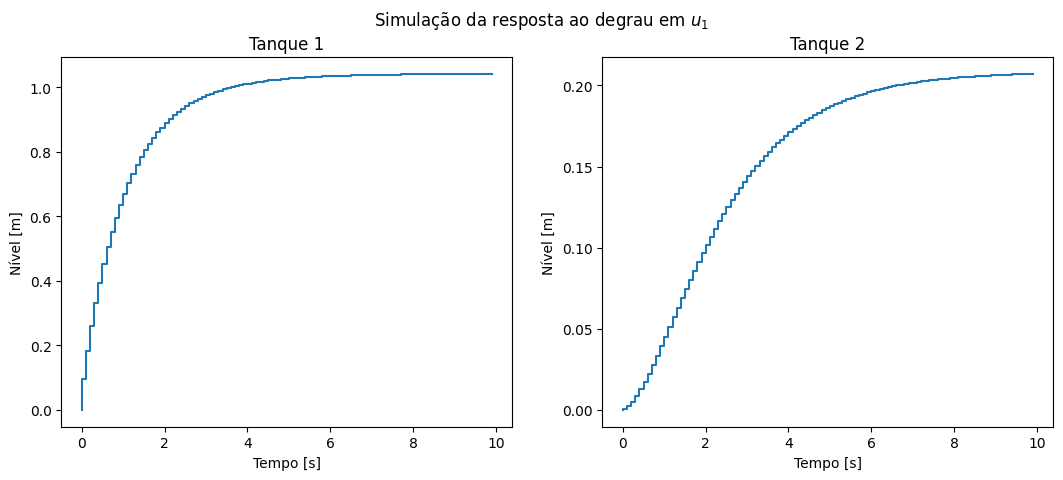

In [9]:
def solve(sys, u = None, k_samples=100):
    A, B, C = sys
    if u is None:
        u = np.ones((B.shape[1], 1))

    xk = np.zeros((2, 1))
    y = np.zeros((k_samples, C.shape[0], 1))

    for k in range(k_samples):
        # print((B @ u).shape)
        y[k] = C @ xk
        xk = A @ xk + B @ u
    return y

k_samples = 100
t = arange(0, k_samples * 0.1, 0.1)
u1 = array([[1, 0]]).T
y_step1 = solve(sys=(Am, Bm, Cm), u=u1, k_samples=k_samples)

# y1 = y[:,0]
figure(figsize=(6.4 * 2, 4.8))
subplot(1, 2, 1)
step(t, y_step1[:,0])
xlabel("Tempo [s]"); ylabel("Nível [m]");

title("Tanque 1")
subplot(1, 2, 2)
step(t, y_step1[:,1])
title("Tanque 2")
xlabel("Tempo [s]"); ylabel("Nível [m]");
suptitle("Simulação da resposta ao degrau em $u_1$");

Para um degrau na entrada 2 ($u_1 = 0$, $u_2 = 1$)

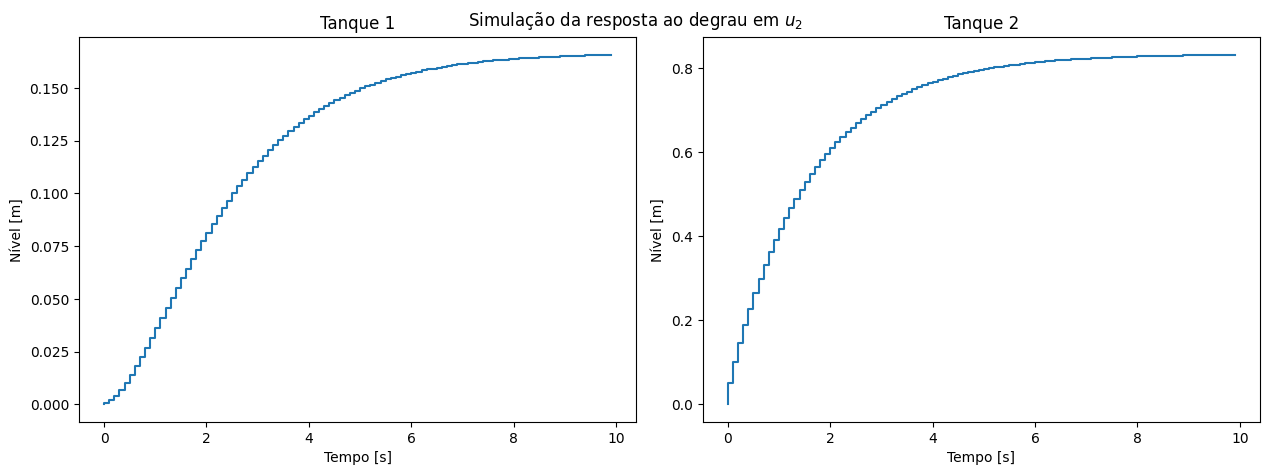

In [10]:
u2 = array([[0, 1]]).T
y_step2 = solve(sys=(Am, Bm, Cm), u=u2, k_samples=k_samples)

figure(figsize=(6.4 * 2, 4.8))
subplot(1, 2, 1)
step(t, y_step2[:,0])
title("Tanque 1")
xlabel("Tempo [s]"); ylabel("Nível [m]");

subplot(1, 2, 2)
step(t, y_step2[:,1])
title("Tanque 2")
xlabel("Tempo [s]"); ylabel("Nível [m]");
tight_layout();
suptitle("Simulação da resposta ao degrau em $u_2$");


In [11]:
def augmented_systemMIMO(A_m, B_m, C_m):
    n = A_m.shape[0]        # número de estados do sistema
    q = C_m.shape[0]        # número de saídas do sistema
    m = B_m.shape[1]        # número de entradas do sistema
    o_m = zeros((q, n))
    _1 = eye(q)
    # para concatenar matrizes em python, usar hstack e vstack

    A = vstack([
        hstack([A_m, o_m.T]),      # Parte superior de A
        hstack([C_m @ A_m, _1]) # Parte inferior de A
    ])

    B = vstack([
        B_m,
        C_m @ B_m
    ])

    C = hstack([o_m, _1])
    return A, B, C

A, B, C = augmented_systemMIMO(Am, Bm, Cm)

## Dimensionalidade

O i-ésimo elemento em $F$ é a matriz $CA^{i}$, que vai até $N_p$, cuja dimensão de cada bloco é $q \times n$.
Já $\Phi$ é composto por blocos da forma $CA^{j-1}B$, cuja dimensão é $q \times m$.

Para o sistema dos tanque duplos temos que o modelo aumentado possui $n_1 = 2 \rightarrow n = n_1 + q = 4$, $m = 2$ e $q = 2$. 

Daí, considerando $N_p = 5$ e $N_c = 3$
- F: possui dimensão $qN_p \times n = 10 \times 4$
- $\Phi$: possui dimensões $qN_p \times mN_c = 10 \times 6$
- $\Phi^T\Phi$: possui dimensão $mN_c \times mN_c$
- $\Phi^TF$: possui dimensão $mN_c \times n$

In [12]:
def mpcgainsMIMO(A, B, C, Np, Nc):
    n = A.shape[0] # número de estados
    m = B.shape[1] # número de entradas
    q = C.shape[0] # número de saídas
    if not (A.shape[0] == A.shape[1]):
        print("A do sistema não é quadrada")
    
    F = C @ A
    for i in range(1, Np):
        F = vstack([F, C @ linalg.matrix_power(A, i)])
    
    Phi = vstack([C@B, F@B])
    Phi = Phi[:-q] # remove um bloco
    shifted = Phi
    for i in range(0, Nc-1):
        shifted = roll(shifted, shift=q, axis=0)  
        shifted[:q, :m] = zeros((q, m))
        Phi = hstack([Phi, shifted])
    return F, Phi

F, Phi = mpcgainsMIMO(A, B, C, 5, 3)
print("Dim(F) = ", F.shape)
print_matrix('F', F)
print("Dim(Phi) = ", Phi.shape)
print_matrix('phi', Phi)

Dim(F) =  (10, 4)


**F:**

```
0.9050 | 0.0184 | 1.0000 | 0.0000
0.0123 | 0.9356 | 0.0000 | 1.0000
0.9050 | 0.0184 | 1.0000 | 0.0000
0.0123 | 0.9356 | 0.0000 | 1.0000
1.7241 | 0.0523 | 1.0000 | 0.0000
0.0348 | 1.8113 | 0.0000 | 1.0000
2.4659 | 0.0990 | 1.0000 | 0.0000
0.0660 | 2.6309 | 0.0000 | 1.0000
3.1377 | 0.1564 | 1.0000 | 0.0000
0.1043 | 3.3984 | 0.0000 | 1.0000
```

Dim(Phi) =  (10, 6)


**phi:**

```
0.0952 | 0.0005 | 0.0000 | 0.0000 | 0.0000 | 0.0000
0.0006 | 0.0516 | 0.0000 | 0.0000 | 0.0000 | 0.0000
0.1813 | 0.0019 | 0.0952 | 0.0005 | 0.0000 | 0.0000
0.0024 | 0.0999 | 0.0006 | 0.0516 | 0.0000 | 0.0000
0.1813 | 0.0019 | 0.1813 | 0.0019 | 0.0952 | 0.0005
0.0024 | 0.0999 | 0.0024 | 0.0999 | 0.0006 | 0.0516
0.2593 | 0.0041 | 0.1813 | 0.0019 | 0.1813 | 0.0019
0.0051 | 0.1451 | 0.0024 | 0.0999 | 0.0024 | 0.0999
0.3299 | 0.0069 | 0.2593 | 0.0041 | 0.1813 | 0.0019
0.0086 | 0.1874 | 0.0051 | 0.1451 | 0.0024 | 0.0999
```

In [21]:
Nc

NameError: name 'Nc' is not defined

In [23]:
bar = F[:, 2:4]
bar

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [24]:
bar @ r

array([[0.8],
       [0.4],
       [0.8],
       [0.4],
       [0.8],
       [0.4],
       [0.8],
       [0.4],
       [0.8],
       [0.4]])

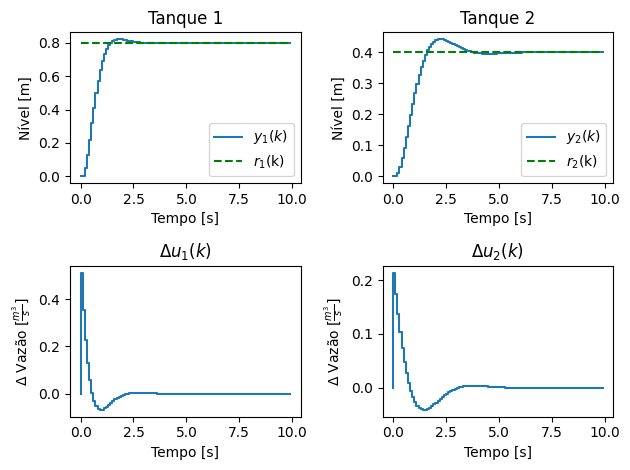

In [16]:
def solveClosedLoop(sys, r = None, k_samples=100):
    N_p = 10
    N_c = 2
    r_w = 3

    A, B, C = sys
    m = B.shape[1]
    n = A.shape[0]
    q = C.shape[0]

    F, Phi = mpcgainsMIMO(A, B, C, N_p, N_c)
    Phi2 = Phi.T @ Phi

    du = zeros((k_samples, B.shape[1], 1)) # Delta u

    xk = zeros((n, 1))                 # X_e(k)
    y = zeros((k_samples, C.shape[0], 1))

    R = eye(m*N_c) * r_w # R barra
    # R_s = ones((N_p, q))
    R_s = F[:, n-q:n]
    
    sel = hstack([eye(m), zeros((m, m*N_c - q))])

    for k in range(1, k_samples):
        # print((B @ u).shape)
        y[k] = C @ xk
        xk = A @ xk + B @ du[k-1]

        E = R_s @ r - F@xk # erro de predição
        W1_inv = linalg.inv(Phi2 + R)
        DeltaU = sel @ W1_inv @ Phi.T @ E
        du[k] = DeltaU
        # print(DeltaU)
    return y, du

k_samples = 100
t = arange(0, k_samples * 0.1, 0.1)
r = array([[0.8, 0.4]]).T
rt = np.ones((len(t), 2)) * r.T
y, du = solveClosedLoop((A, B, C), r, k_samples=100)

# figure(figsize=(6.4, 4.8))
subplot(2, 2, 1)
step(t, y[:,0], label="$y_1(k)$")
plot(t, rt[:, 0], '--g', label="$r_1$(k)")
title("Tanque 1")
xlabel("Tempo [s]"); ylabel("Nível [m]");
legend()

subplot(2, 2, 2)
step(t, y[:,1], label="$y_2(k)$")
plot(t, rt[:, 1], '--g', label="$r_2$(k)")
title("Tanque 2")
xlabel("Tempo [s]"); ylabel("Nível [m]");
legend()

subplot(2, 2, 3)
step(t, du[:, 0])
title("$\Delta u_1 (k) $")
xlabel("Tempo [s]"); ylabel("$\Delta$ Vazão [$\\frac{m^3}{s}$]");
tight_layout();

subplot(2, 2, 4)
step(t, du[:, 1])
title("$\Delta u_2 (k) $")
xlabel("Tempo [s]"); ylabel("$\Delta$ Vazão [$\\frac{m^3}{s}$]");
tight_layout();

# tight_layout();
# suptitle("Simulação da resposta ao degrau em $u_2$");